In [1]:
import pandas as pd
import numpy as np
import pmdarima as pm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Load the dataset
data = pd.read_csv(r'D:\study\tieu_luan_chuyen_nganh\demo\timeseries_hybrid\data\goldprice\gld_price_data.csv')
print(data.head())

       Date          SPX        GLD        USO     SLV   EUR/USD
0  1/2/2008  1447.160034  84.860001  78.470001  15.180  1.471692
1  1/3/2008  1447.160034  85.570000  78.370003  15.285  1.474491
2  1/4/2008  1411.630005  85.129997  77.309998  15.167  1.475492
3  1/7/2008  1416.180054  84.769997  75.500000  15.053  1.468299
4  1/8/2008  1390.189941  86.779999  76.059998  15.590  1.557099


In [3]:
df = data[['Date', 'GLD']].copy()
df['Date'] = pd.to_datetime(df['Date'])
print(df.head())

        Date        GLD
0 2008-01-02  84.860001
1 2008-01-03  85.570000
2 2008-01-04  85.129997
3 2008-01-07  84.769997
4 2008-01-08  86.779999


In [4]:
def fill_missing_values(df, column):
    # Lặp qua từng giá trị trong cột, tìm các giá trị thiếu (NaN)
    for idx in range(1, len(df) - 1):
        if pd.isna(df.loc[idx, column]):
            # Tìm giá trị trước đó không bị thiếu
            prev_idx = idx - 1
            while prev_idx >= 0 and pd.isna(df.loc[prev_idx, column]):
                prev_idx -= 1
            
            # Tìm giá trị sau đó không bị thiếu
            next_idx = idx + 1
            while next_idx < len(df) and pd.isna(df.loc[next_idx, column]):
                next_idx += 1

            # Nếu tìm được giá trị trước và sau, áp dụng công thức nội suy
            if prev_idx >= 0 and next_idx < len(df):
                a_value = df.loc[prev_idx, column]
                b_value = df.loc[next_idx, column]
                index_a = prev_idx
                index_b = next_idx
                index_x = idx

                # Công thức nội suy tuyến tính
                x_value = a_value + (index_x - index_a) / (index_b - index_a) * (b_value - a_value)
                
                # Điền giá trị đã tính vào vị trí thiếu
                df.loc[idx, column] = x_value

    return df
    
def fill_missing_values_date(df, date, column):
    # Tạo DataFrame với tất cả các ngày (bao gồm cả thứ 7, chủ nhật)
    all_days = pd.date_range(start=df[date].min(), end=df[date].max(), freq='D')
    df_all = pd.DataFrame({date: all_days})
    
    # Kết hợp dữ liệu gốc với DataFrame chứa tất cả các ngày
    df_merged = pd.merge(df_all, df, on=date, how='left')
    df_merged['index'] = range(1, len(df_merged) + 1)
    df_merged = fill_missing_values(df_merged, column)
    df_merged = df_merged.drop(columns=['index'])
    return df_merged

df = fill_missing_values_date(df, 'Date', 'GLD')
df.head(10)

,Date,GLD
0,2008-01-02,84.860001
1,2008-01-03,85.570000
2,2008-01-04,85.129997
3,2008-01-05,85.009997
4,2008-01-06,84.889997
5,2008-01-07,84.769997
6,2008-01-08,86.779999
7,2008-01-09,86.550003
8,2008-01-10,88.250000
9,2008-01-11,88.580002


In [5]:
df.set_index('Date', inplace=True)

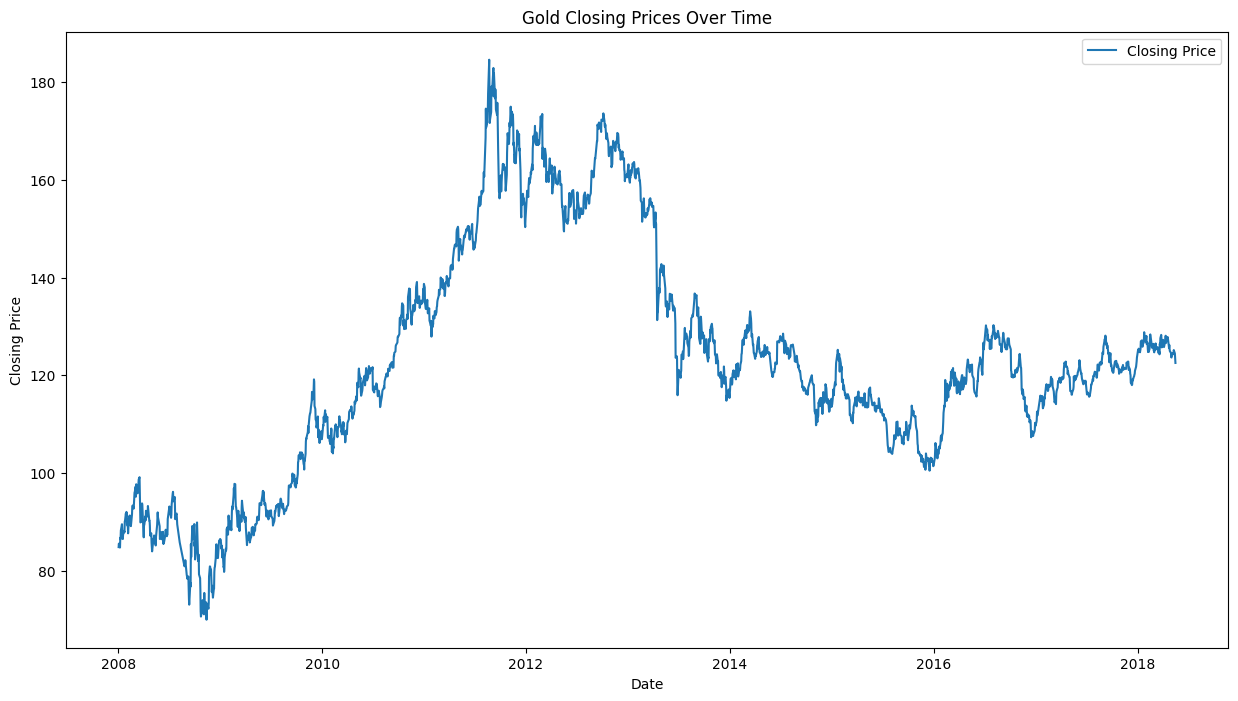

In [6]:
# Visualize the data
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['GLD'], label='Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Gold Closing Prices Over Time')
plt.legend()
plt.show()

In [7]:
# Create training and testing datasets
train_start_dt = '2008-01-01'
test_start_dt = '2017-01-01'
train = df.loc[train_start_dt:test_start_dt]
test = df.loc[test_start_dt:]
train.head()

,GLD
Date,
2008-01-02,84.860001
2008-01-03,85.570000
2008-01-04,85.129997
2008-01-05,85.009997
2008-01-06,84.889997


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 501 entries, 2017-01-01 to 2018-05-16
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GLD     501 non-null    float64
dtypes: float64(1)
memory usage: 7.8 KB


# Huan luyen model

In [9]:
# Sử dụng auto_arima để tìm tham số p, d, q tốt nhất
auto_arima_model = pm.auto_arima(train['GLD'], 
                                 start_p=1, start_q=1,  # Khởi đầu cho p và q
                                 max_p=5, max_q=5,  # Giới hạn tối đa của p và q
                                 start_d=0, max_d=5,  # Tìm d trong khoảng từ 0 đến 2 (hoặc hơn nếu cần)
                                 seasonal=False,  # Dữ liệu không có tính chu kỳ
                                 trace=True,  # Hiển thị kết quả của mỗi lần thử nghiệm
                                 stepwise=True)  # Sử dụng phương pháp tìm kiếm tối ưu


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9706.611, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9735.271, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9711.594, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9714.208, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9733.442, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9706.081, Time=1.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9704.100, Time=0.51 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=9706.066, Time=0.62 sec


KeyboardInterrupt: 

In [15]:
print(auto_arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3288
Model:               SARIMAX(2, 1, 0)   Log Likelihood               -4848.115
Date:                Fri, 25 Oct 2024   AIC                           9702.230
Time:                        16:58:28   BIC                           9720.523
Sample:                    01-02-2008   HQIC                          9708.779
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0835      0.010      8.103      0.000       0.063       0.104
ar.L2          0.0537      0.014      3.769      0.000       0.026       0.082
sigma2         1.1185      0.012     93.334      0.0

In [16]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

history = [x for x in train['GLD']]
predictions = list()

# walk-forward validation
for t in range(len(test['GLD'])):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test['GLD'][t]
    history.append(obs)

# Plot the original data and the forecast
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(train['GLD'])), train['GLD'], label="Train")
plt.plot(np.arange(len(train['GLD'])+1, len(train['GLD']) + len(test['GLD'])+1), predictions, label="Forecasted Values", color='red')
plt.title('ARIMA Prediction using predict()')
plt.xlabel('Time')
plt.ylabel('Log Return')
plt.legend()
plt.show()

C:\Users\nhath\AppData\Local\Temp\ipykernel_21864\3194538051.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obs = test['GLD'][t]


KeyboardInterrupt: 

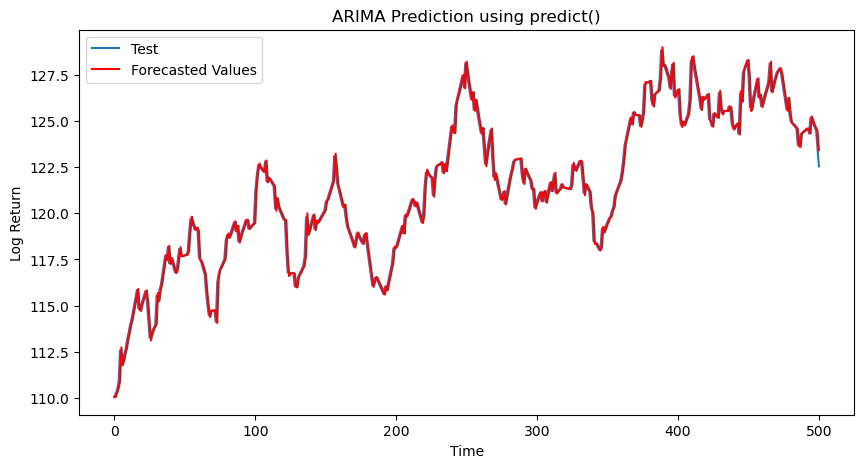

In [12]:
# Plot the original data and the forecast
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(test['GLD'])), test['GLD'], label="Test")
plt.plot(np.arange(len(test['GLD'])), predictions, label="Forecasted Values", color='red')
plt.title('ARIMA Prediction using predict()')
plt.xlabel('Time')
plt.ylabel('Log Return')
plt.legend()
plt.show()

In [13]:
# Tính toán các chỉ số đánh giá mô hình
mse = mean_squared_error(test['GLD'], predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['GLD'], predictions)
mape = np.mean(np.abs((test['GLD'] - predictions) / test['GLD'])) * 100
r2 = r2_score(test['GLD'], predictions)

# In các chỉ số
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}%')
print(f'R²: {r2}')

MSE: 0.297848302042506
RMSE: 0.5457548002926828
MAE: 0.3884430057035625
MAPE: 0.3195327467670592%
R²: 0.9811114260956944


# có chuẩn hóa

In [14]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform it
train_scaled = train.copy()
train_scaled['GLD'] = scaler.fit_transform(train[['GLD']])

# Transform the test data using the same scaler
test_scaled = test.copy()
test_scaled['GLD'] = scaler.transform(test[['GLD']])

In [15]:
train_scaled

,GLD
Date,
2008-01-02,0.129680
2008-01-03,0.135876
2008-01-04,0.132036
2008-01-05,0.130989
2008-01-06,0.129942
...,...
2016-12-28,0.339122
2016-12-29,0.351601
2016-12-30,0.345667


In [16]:
# Find the best parameters using auto_arima on the scaled training data
auto_arima_model = pm.auto_arima(train_scaled['GLD'], 
                                 start_p=1, start_q=1,
                                 max_p=5, max_q=5,
                                 start_d=0, max_d=5,
                                 seasonal=False,
                                 trace=True,
                                 stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-21462.310, Time=4.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-21434.433, Time=0.58 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-21458.109, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-21455.434, Time=6.86 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-21436.262, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-21463.609, Time=7.50 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-21465.604, Time=5.97 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-21463.638, Time=2.82 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-21461.655, Time=9.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-21467.474, Time=1.92 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-21459.966, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-21465.509, Time=5.82 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-21465.480, Time=5.65 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-21464.179, Time=1.59 sec
 ARIM

In [17]:
print(auto_arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3288
Model:               SARIMAX(2, 1, 0)   Log Likelihood               10736.737
Date:                Tue, 22 Oct 2024   AIC                         -21467.474
Time:                        12:43:51   BIC                         -21449.181
Sample:                    01-02-2008   HQIC                        -21460.925
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0836      0.010      8.113      0.000       0.063       0.104
ar.L2          0.0538      0.014      3.770      0.000       0.026       0.082
sigma2      8.518e-05   9.13e-07     93.340      0.0

In [18]:
# Walk-forward validation with the scaled data
history = [x for x in train_scaled['GLD']]
predictions = list()

for t in range(len(test_scaled['GLD'])):
    model = ARIMA(history, order=(2, 1, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_scaled['GLD'][t]
    history.append(obs)

C:\Users\trumx\AppData\Local\Temp\ipykernel_22616\232680071.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obs = test_scaled['GLD'][t]


In [19]:
predictions_inverse = scaler.inverse_transform([predictions])[0]

In [20]:
# Tính toán các chỉ số đánh giá mô hình
mse_arima = mean_squared_error(test['GLD'], predictions_inverse)
rmse_arima = np.sqrt(mse)
mae_arima = mean_absolute_error(test['GLD'], predictions_inverse)
mape_arima = np.mean(np.abs((test['GLD'] - predictions_inverse) / test['GLD'])) * 100
r2_arima = r2_score(test['GLD'], predictions_inverse)

# In các chỉ số
print(f'MSE: {mse_arima}')
print(f'RMSE: {rmse_arima}')
print(f'MAE: {mae_arima}')
print(f'MAPE: {mape_arima}%')
print(f'R²: {r2_arima}')

MSE: 0.29784820894313396
RMSE: 0.5457548002926828
MAE: 0.3884403897219211
MAPE: 0.31953051478692734%
R²: 0.9811114319997548


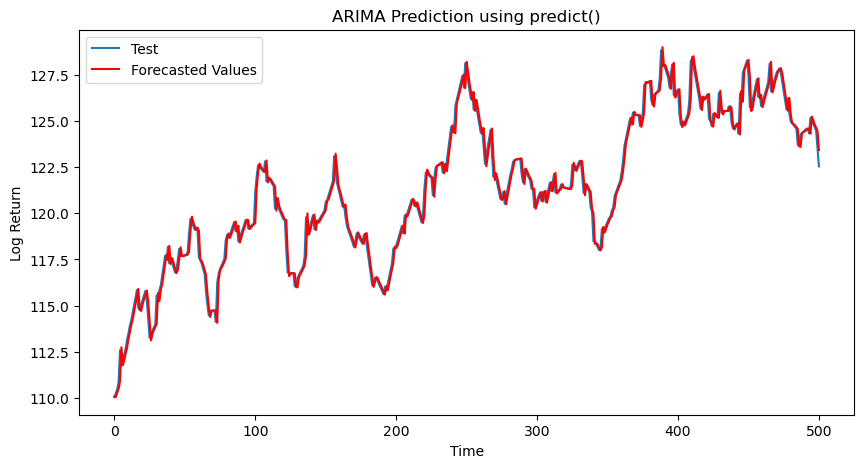

In [21]:
# Plot the original data and the forecast
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(test['GLD'])), test['GLD'], label="Test")
plt.plot(np.arange(len(test['GLD'])), predictions_inverse, label="Forecasted Values", color='red')
plt.title('ARIMA Prediction using predict()')
plt.xlabel('Time')
plt.ylabel('Log Return')
plt.legend()
plt.show()

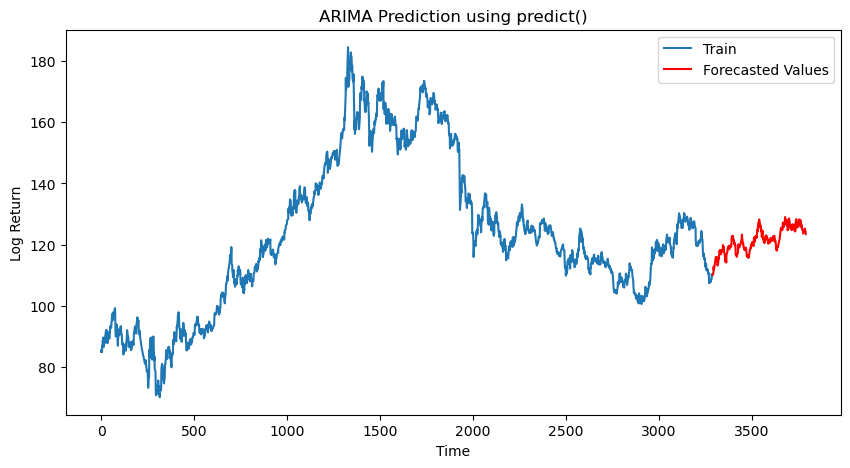

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(train['GLD'])), train['GLD'], label="Train")
plt.plot(np.arange(len(train['GLD'])+1, len(train['GLD']) + len(test['GLD'])+1), predictions_inverse, label="Forecasted Values", color='red')
plt.title('ARIMA Prediction using predict()')
plt.xlabel('Time')
plt.ylabel('Log Return')
plt.legend()
plt.show()

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

In [24]:
# Load the dataset
data = pd.read_csv('gld_price_data.csv')
print(data.head())

       Date          SPX        GLD        USO     SLV   EUR/USD
0  1/2/2008  1447.160034  84.860001  78.470001  15.180  1.471692
1  1/3/2008  1447.160034  85.570000  78.370003  15.285  1.474491
2  1/4/2008  1411.630005  85.129997  77.309998  15.167  1.475492
3  1/7/2008  1416.180054  84.769997  75.500000  15.053  1.468299
4  1/8/2008  1390.189941  86.779999  76.059998  15.590  1.557099


In [25]:
df = data[['Date', 'GLD']].copy()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
print(df.head())


                  GLD
Date                 
2008-01-02  84.860001
2008-01-03  85.570000
2008-01-04  85.129997
2008-01-07  84.769997
2008-01-08  86.779999


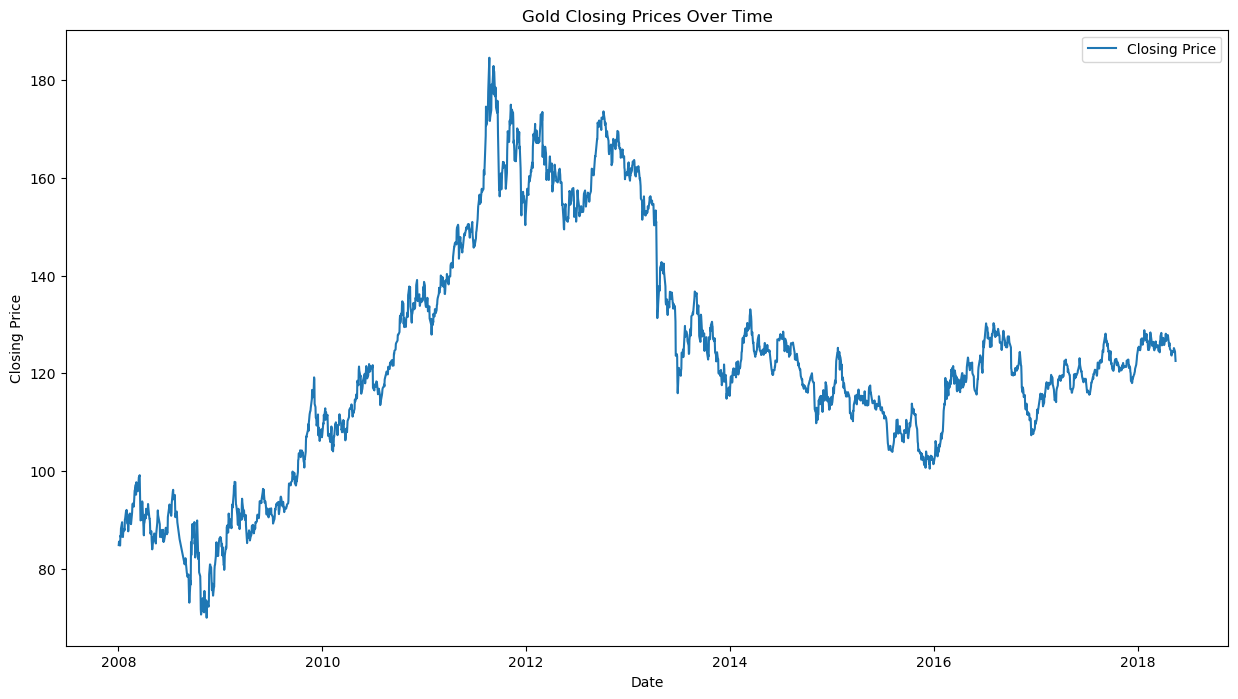

In [26]:
# Visualize the data
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['GLD'], label='Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Gold Closing Prices Over Time')
plt.legend()
plt.show()

In [27]:
# Create training and testing datasets
train_start_dt = '2008-01-01'
test_start_dt = '2017-01-01'
train = df.loc[train_start_dt:test_start_dt]
test = df.loc[test_start_dt:]
train.head()


,GLD
Date,
2008-01-02,84.860001
2008-01-03,85.570000
2008-01-04,85.129997
2008-01-07,84.769997
2008-01-08,86.779999


In [28]:
# Scale the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [29]:
# Prepare the data for training
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:i + time_steps]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 5
X_train, y_train = create_dataset(train_scaled, train_scaled, TIME_STEPS)
X_test, y_test = create_dataset(test_scaled, test_scaled, TIME_STEPS)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1980, 5, 1) (1980, 1)
(300, 5, 1) (300, 1)


In [30]:
# Define the parameter grid for Grid Search
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.05, 0.1, 0.5],
    'gamma': ['scale', 'auto', 0.1, 0.5, 1],
    'kernel': ['linear', 'rbf', 'sigmoid']
}

In [31]:
# Perform Grid Search with 5-fold Cross-Validation
grid_search = GridSearchCV(estimator=SVR(), param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5, verbose=2)


In [32]:
# Fit the model to the training data
grid_search.fit(X_train.reshape(X_train.shape[0], -1), y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV] END ....C=0.1, epsilon=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ....C=0.1, epsilon=0.01, gamma=scale, kernel=linear; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....C=0.1, epsilon=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ....C=0.1, epsilon=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ....C=0.1, epsilon=0.01, gamma=scale, kernel=linear; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=0.1, epsilon=0.01, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .......C=0.1, epsilon=0.01, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .......C=0.1, epsilon=0.01, gamma=scale, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=0.1, epsilon=0.01, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .......C=0.1, epsilon=0.01, gamma=scale, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...C=0.1, epsilon=0.01, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...C=0.1, epsilon=0.01, gamma=scale, kernel=sigmoid; total time=   0.1s
[CV] END ...C=0.1, epsilon=0.01, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...C=0.1, epsilon=0.01, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...C=0.1, epsilon=0.01, gamma=scale, kernel=sigmoid; total time=   0.1s
[CV] END .....C=0.1, epsilon=0.01, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .....C=0.1, epsilon=0.01, gamma=auto, kernel=linear; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=0.1, epsilon=0.01, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .....C=0.1, epsilon=0.01, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .....C=0.1, epsilon=0.01, gamma=auto, kernel=linear; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, epsilon=0.01, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ........C=0.1, epsilon=0.01, gamma=auto, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, epsilon=0.01, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ........C=0.1, epsilon=0.01, gamma=auto, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, epsilon=0.01, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, epsilon=0.01, gamma=auto, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....C=0.1, epsilon=0.01, gamma=auto, kernel=sigmoid; total time=   0.1s
[CV] END ....C=0.1, epsilon=0.01, gamma=auto, kernel=sigmoid; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....C=0.1, epsilon=0.01, gamma=auto, kernel=sigmoid; total time=   0.1s
[CV] END ....C=0.1, epsilon=0.01, gamma=auto, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=0.1, epsilon=0.01, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ......C=0.1, epsilon=0.01, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ......C=0.1, epsilon=0.01, gamma=0.1, kernel=linear; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=0.1, epsilon=0.01, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ......C=0.1, epsilon=0.01, gamma=0.1, kernel=linear; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=0.1, epsilon=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........C=0.1, epsilon=0.01, gamma=0.1, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=0.1, epsilon=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........C=0.1, epsilon=0.01, gamma=0.1, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=0.1, epsilon=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, epsilon=0.01, gamma=0.1, kernel=sigmoid; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=0.1, epsilon=0.01, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.1, epsilon=0.01, gamma=0.1, kernel=sigmoid; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=0.1, epsilon=0.01, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.1, epsilon=0.01, gamma=0.1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=0.1, epsilon=0.01, gamma=0.5, kernel=linear; total time=   0.0s
[CV] END ......C=0.1, epsilon=0.01, gamma=0.5, kernel=linear; total time=   0.0s
[CV] END ......C=0.1, epsilon=0.01, gamma=0.5, kernel=linear; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=0.1, epsilon=0.01, gamma=0.5, kernel=linear; total time=   0.0s
[CV] END ......C=0.1, epsilon=0.01, gamma=0.5, kernel=linear; total time=   0.0s
[CV] END .........C=0.1, epsilon=0.01, gamma=0.5, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=0.1, epsilon=0.01, gamma=0.5, kernel=rbf; total time=   0.0s
[CV] END .........C=0.1, epsilon=0.01, gamma=0.5, kernel=rbf; total time=   0.0s
[CV] END .........C=0.1, epsilon=0.01, gamma=0.5, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=0.1, epsilon=0.01, gamma=0.5, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, epsilon=0.01, gamma=0.5, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=0.1, epsilon=0.01, gamma=0.5, kernel=sigmoid; total time=   0.1s
[CV] END .....C=0.1, epsilon=0.01, gamma=0.5, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=0.1, epsilon=0.01, gamma=0.5, kernel=sigmoid; total time=   0.1s
[CV] END .....C=0.1, epsilon=0.01, gamma=0.5, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, epsilon=0.01, gamma=1, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, epsilon=0.01, gamma=1, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, epsilon=0.01, gamma=1, kernel=linear; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, epsilon=0.01, gamma=1, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, epsilon=0.01, gamma=1, kernel=linear; total time=   0.0s
[CV] END ...........C=0.1, epsilon=0.01, gamma=1, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, epsilon=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.1, epsilon=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.1, epsilon=0.01, gamma=1, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=0.1, epsilon=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .......C=0.1, epsilon=0.01, gamma=1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=0.1, epsilon=0.01, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END .......C=0.1, epsilon=0.01, gamma=1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=0.1, epsilon=0.01, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END .......C=0.1, epsilon=0.01, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END ....C=0.1, epsilon=0.05, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ....C=0.1, epsilon=0.05, gamma=scale, kernel=linear; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END ....C=0.1, epsilon=0.05, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ....C=0.1, epsilon=0.05, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ....C=0.1, epsilon=0.05, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .......C=0.1, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .......C=0.1, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .......C=0.1, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .......C=0.1, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .......C=0.1, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END ...C=0.1, epsilon=0.05, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...C=0.1, epsilon=0.05, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...C=0.1, epsilon=0.05, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...C=0.1, epsilon=0.05, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...C=0.1, epsilon=0.05, gamma=scale, kernel=sigmoid; total time=   0.1s
[CV] END .....C=0.1, epsilon=0.05, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .....C=0.1, epsilon=0.05, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .....C=0.1, epsilon=0.05, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .....C=0.1, epsilon=0.05, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .....C=0.1, epsilon=0.05, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, epsilon=0.05, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ........C=0.1, epsilon=0.05, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ........C=0.1, epsilon=0.05, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ........C=0.1, epsilon=0.05, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ........C=0.1, epsilon=0.05, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, epsilon=0.05, gamma=auto, kernel=sigmoid; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END ....C=0.1, epsilon=0.05, gamma=auto, kernel=sigmoid; total time=   0.1s
[CV] END ....C=0.1, epsilon=0.05, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ....C=0.1, epsilon=0.05, gamma=auto, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....C=0.1, epsilon=0.05, gamma=auto, kernel=sigmoid; total time=   0.1s
[CV] END ......C=0.1, epsilon=0.05, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ......C=0.1, epsilon=0.05, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ......C=0.1, epsilon=0.05, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ......C=0.1, epsilon=0.05, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ......C=0.1, epsilon=0.05, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .........C=0.1, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........C=0.1, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........C=0.1, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........C=0.1, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........C=0.1, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, epsilon=0.05, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.1, epsilon

D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END .........C=0.1, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   0.0s
[CV] END .........C=0.1, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   0.0s
[CV] END .........C=0.1, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, epsilon=0.05, gamma=0.5, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END .....C=0.1, epsilon=0.05, gamma=0.5, kernel=sigmoid; total time=   0.1s
[CV] END .....C=0.1, epsilon=0.05, gamma=0.5, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=0.1, epsilon=0.05, gamma=0.5, kernel=sigmoid; total time=   0.1s
[CV] END .....C=0.1, epsilon=0.05, gamma=0.5, kernel=sigmoid; total time=   0.1s
[CV] END ........C=0.1, epsilon=0.05, gamma=1, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, epsilon=0.05, gamma=1, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, epsilon=0.05, gamma=1, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, epsilon=0.05, gamma=1, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, epsilon=0.05, gamma=1, kernel=linear; total time=   0.0s
[CV] END ...........C=0.1, epsilon=0.05, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.1, epsilon=0.05, gamma=1, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END ...........C=0.1, epsilon=0.05, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.1, epsilon=0.05, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.1, epsilon=0.05, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .......C=0.1, epsilon=0.05, gamma=1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END .......C=0.1, epsilon=0.05, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END .......C=0.1, epsilon=0.05, gamma=1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=0.1, epsilon=0.05, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END .......C=0.1, epsilon=0.05, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END .....C=0.1, epsilon=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....C=0.1, epsilon=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....C=0.1, epsilon=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....C=0.1, epsilon=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....C=0.1, epsilon=0.1, gamma=scale, kernel=linear; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END ........C=0.1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=0.1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=0.1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=0.1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=0.1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, epsilon=0.1, gamma=scale, kernel=sigmoid; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END ....C=0.1, epsilon=0.1, gamma=scale, kernel=sigmoid; total time=   0.1s
[CV] END ....C=0.1, epsilon=0.1, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....C=0.1, epsilon=0.1, gamma=scale, kernel=sigmoid; total time=   0.1s
[CV] END ....C=0.1, epsilon=0.1, gamma=scale, kernel=sigmoid; total time=   0.1s
[CV] END ......C=0.1, epsilon=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ......C=0.1, epsilon=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ......C=0.1, epsilon=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ......C=0.1, epsilon=0.1, gamma=auto, kernel=linear; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END ......C=0.1, epsilon=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .........C=0.1, epsilon=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .........C=0.1, epsilon=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .........C=0.1, epsilon=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .........C=0.1, epsilon=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .........C=0.1, epsilon=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, epsilon=0.1, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.1, epsilon=0.1, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.1, epsilon=0.1, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.1, epsilon=0.1, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END .....C=0.1, epsilon=0.1, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.1, epsilon=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .......C=0.1, epsil

D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END ......C=0.1, epsilon=0.1, gamma=0.5, kernel=sigmoid; total time=   0.1s
[CV] END ......C=0.1, epsilon=0.1, gamma=0.5, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=0.1, epsilon=0.1, gamma=0.5, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.1, epsilon=0.1, gamma=0.5, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=0.1, epsilon=0.1, gamma=0.5, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0.1, epsilon=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END .........C=0.1, epsilon=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END .........C=0.1, epsilon=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END .........C=0.1, epsilon=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END .........C=0.1, epsilon=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ............C=0.1, epsilon=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ............C=0.1, epsilon=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ............C=0.1, epsilon=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ............C=0.1, epsilon=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ............C=0.1, epsilon=0.1, gamma=1, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END ........C=0.1, epsilon=0.1, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END ........C=0.1, epsilon=0.1, gamma=1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, epsilon=0.1, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END ........C=0.1, epsilon=0.1, gamma=1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=0.1, epsilon=0.1, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END .....C=0.1, epsilon=0.5, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....C=0.1, epsilon=0.5, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....C=0.1, epsilon=0.5, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....C=0.1, epsilon=0.5, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....C=0.1, epsilon=0.5, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, epsilon=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=0.1, epsilon=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=0.1, epsilon=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=0.1, epsilon=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=0.1, epsilon=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, epsilon=0.5, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ....C=0.1, epsilon=

D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END ......C=1, epsilon=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=1, epsilon=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=1, epsilon=0.01, gamma=scale, kernel=linear; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=1, epsilon=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=1, epsilon=0.01, gamma=scale, kernel=linear; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=1, epsilon=0.01, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=1, epsilon=0.01, gamma=scale, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=1, epsilon=0.01, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=1, epsilon=0.01, gamma=scale, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=1, epsilon=0.01, gamma=scale, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=1, epsilon=0.01, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=1, epsilon=0.01, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=1, epsilon=0.01, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=1, epsilon=0.01, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=1, epsilon=0.01, gamma=scale, kernel=sigmoid; total time=   0.1s
[CV] END .......C=1, epsilon=0.01, gamma=auto, kernel=linear; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=1, epsilon=0.01, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .......C=1, epsilon=0.01, gamma=auto, kernel=linear; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=1, epsilon=0.01, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .......C=1, epsilon=0.01, gamma=auto, kernel=linear; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=1, epsilon=0.01, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.01, gamma=auto, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=1, epsilon=0.01, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.01, gamma=auto, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=1, epsilon=0.01, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......C=1, epsilon=0.01, gamma=auto, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=1, epsilon=0.01, gamma=auto, kernel=sigmoid; total time=   0.1s
[CV] END ......C=1, epsilon=0.01, gamma=auto, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=1, epsilon=0.01, gamma=auto, kernel=sigmoid; total time=   0.1s
[CV] END ......C=1, epsilon=0.01, gamma=auto, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=1, epsilon=0.01, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ........C=1, epsilon=0.01, gamma=0.1, kernel=linear; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=1, epsilon=0.01, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ........C=1, epsilon=0.01, gamma=0.1, kernel=linear; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=1, epsilon=0.01, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ...........C=1, epsilon=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.01, gamma=0.1, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.01, gamma=0.1, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......C=1, epsilon=0.01, gamma=0.1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=1, epsilon=0.01, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .......C=1, epsilon=0.01, gamma=0.1, kernel=sigmoid; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=1, epsilon=0.01, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .......C=1, epsilon=0.01, gamma=0.1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=1, epsilon=0.01, gamma=0.5, kernel=linear; total time=   0.0s
[CV] END ........C=1, epsilon=0.01, gamma=0.5, kernel=linear; total time=   0.0s
[CV] END ........C=1, epsilon=0.01, gamma=0.5, kernel=linear; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=1, epsilon=0.01, gamma=0.5, kernel=linear; total time=   0.0s
[CV] END ........C=1, epsilon=0.01, gamma=0.5, kernel=linear; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.5, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.01, gamma=0.5, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.01, gamma=0.5, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.5, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.01, gamma=0.5, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=1, epsilon=0.01, gamma=0.5, kernel=sigmoid; total time=   0.1s
[CV] END .......C=1, epsilon=0.01, gamma=0.5, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=1, epsilon=0.01, gamma=0.5, kernel=sigmoid; total time=   0.1s
[CV] END .......C=1, epsilon=0.01, gamma=0.5, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=1, epsilon=0.01, gamma=0.5, kernel=sigmoid; total time=   0.1s
[CV] END ..........C=1, epsilon=0.01, gamma=1, kernel=linear; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=1, epsilon=0.01, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..........C=1, epsilon=0.01, gamma=1, kernel=linear; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=1, epsilon=0.01, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..........C=1, epsilon=0.01, gamma=1, kernel=linear; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .............C=1, epsilon=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .............C=1, epsilon=0.01, gamma=1, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .............C=1, epsilon=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .............C=1, epsilon=0.01, gamma=1, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .............C=1, epsilon=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........C=1, epsilon=0.01, gamma=1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=1, epsilon=0.01, gamma=1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=1, epsilon=0.01, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END .........C=1, epsilon=0.01, gamma=1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=1, epsilon=0.01, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END ......C=1, epsilon=0.05, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=1, epsilon=0.05, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=1, epsilon=0.05, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=1, epsilon=0.05, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=1, epsilon=0.05, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .........C=1, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=1, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=1, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=1, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=1, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END .....C=1, epsilon=0.05, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=1, epsilon=0.05, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=1, epsilon=0.05, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=1, epsilon=0.05, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=1, epsilon=0.05, gamma=scale, kernel=sigmoid; total time=   0.1s
[CV] END .......C=1, epsilon=0.05, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .......C=1, epsilon=0.05, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .......C=1, epsilon=0.05, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .......C=1, epsilon=0.05, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .......C=1, epsilon=0.05, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ..........C=1, epsilon=0.05, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.05, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.05, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.05, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.05, gamma=auto, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END ......C=1, epsilon=0.05, gamma=auto, kernel=sigmoid; total time=   0.1s
[CV] END ......C=1, epsilon=0.05, gamma=auto, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=1, epsilon=0.05, gamma=auto, kernel=sigmoid; total time=   0.1s
[CV] END ......C=1, epsilon=0.05, gamma=auto, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=1, epsilon=0.05, gamma=auto, kernel=sigmoid; total time=   0.1s
[CV] END ........C=1, epsilon=0.05, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ........C=1, epsilon=0.05, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ........C=1, epsilon=0.05, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ........C=1, epsilon=0.05, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ........C=1, epsilon=0.05, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ...........C=1, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......C=1, epsilon=0.05, gamma=0.1, kernel=sigmoid; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END .......C=1, epsilon=0.05, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .......C=1, epsilon=0.05, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .......C=1, epsilon=0.05, gamma=0.1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=1, epsilon=0.05, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END ........C=1, epsilon=0.05, gamma=0.5, kernel=linear; total time=   0.0s
[CV] END ........C=1, epsilon=0.05, gamma=0.5, kernel=linear; total time=   0.0s
[CV] END ........C=1, epsilon=0.05, gamma=0.5, kernel=linear; total time=   0.0s
[CV] END ........C=1, epsilon=0.05, gamma=0.5, kernel=linear; total time=   0.0s
[CV] END ........C=1, epsilon=0.05, gamma=0.5, kernel=linear; total time=   0.0s
[CV] END ...........C=1, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END .......C=1, epsilon=0.05, gamma=0.5, kernel=sigmoid; total time=   0.1s
[CV] END .......C=1, epsilon=0.05, gamma=0.5, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=1, epsilon=0.05, gamma=0.5, kernel=sigmoid; total time=   0.1s
[CV] END .......C=1, epsilon=0.05, gamma=0.5, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=1, epsilon=0.05, gamma=0.5, kernel=sigmoid; total time=   0.1s
[CV] END ..........C=1, epsilon=0.05, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..........C=1, epsilon=0.05, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..........C=1, epsilon=0.05, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..........C=1, epsilon=0.05, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..........C=1, epsilon=0.05, gamma=1, kernel=linear; total time=   0.0s
[CV] END .............C=1, epsilon=0.05, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .............C=1, epsilon=0.05, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .............C=1, epsilon=0.05, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .............C=1, epsilon=0.05, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .............C=1, epsilon=0.05, gamma=1, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END .........C=1, epsilon=0.05, gamma=1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=1, epsilon=0.05, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END .........C=1, epsilon=0.05, gamma=1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=1, epsilon=0.05, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END .........C=1, epsilon=0.05, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END .......C=1, epsilon=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .......C=1, epsilon=0.1, gamma=scale, kernel=linear; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END .......C=1, epsilon=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .......C=1, epsilon=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .......C=1, epsilon=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ......C=1, epsilon=0.1, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END ......C=1, epsilon=0.1, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=1, epsilon=0.1, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=1, epsilon=0.1, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=1, epsilon=0.1, gamma=scale, kernel=sigmoid; total time=   0.1s
[CV] END ........C=1, epsilon=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ........C=1, epsilon=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ........C=1, epsilon=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ........C=1, epsilon=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ........C=1, epsilon=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ...........C=1, epsilon=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .......C=1, epsilon=0.1, gamma=auto, kernel=sigmoid; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END .......C=1, epsilon=0.1, gamma=auto, kernel=sigmoid; total time=   0.1s
[CV] END .......C=1, epsilon=0.1, gamma=auto, kernel=sigmoid; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=1, epsilon=0.1, gamma=auto, kernel=sigmoid; total time=   0.1s
[CV] END .......C=1, epsilon=0.1, gamma=auto, kernel=sigmoid; total time=   0.1s
[CV] END .........C=1, epsilon=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .........C=1, epsilon=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .........C=1, epsilon=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .........C=1, epsilon=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .........C=1, epsilon=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ........C=1, epsilon=0.1, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ........C=1, epsilon=0.1, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ........C=1, epsilon=0.1, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ........C=1, epsilon=0.1, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ........C=1, epsilon=0.1, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .........C=1, epsilon=0.1, gamma=0.5, kernel=linear; total time=   0.0s
[CV] END .........C=1, epsilon=0.1, gamma=0.5, kernel=linear; total time=   0.0s
[CV] END .........C=1, epsilon=0.1, gamma=0.5, kernel=linear; total time=   0.0s
[CV] END .........C=1, epsilon=0.1, gamma=0.5, kernel=linear; total time=   0.0s
[CV] END .........C=1, epsilon=0.1, gamma=0.5, kernel=linear; total time=   0.0s
[CV] END ............C=1, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   0.0s
[CV] END ............C=1, ep

D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END ........C=1, epsilon=0.1, gamma=0.5, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=1, epsilon=0.1, gamma=0.5, kernel=sigmoid; total time=   0.1s
[CV] END ........C=1, epsilon=0.1, gamma=0.5, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=1, epsilon=0.1, gamma=0.5, kernel=sigmoid; total time=   0.1s
[CV] END ........C=1, epsilon=0.1, gamma=0.5, kernel=sigmoid; total time=   0.1s
[CV] END ...........C=1, epsilon=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ...........C=1, epsilon=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ...........C=1, epsilon=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ...........C=1, epsilon=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ...........C=1, epsilon=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..............C=1, epsilon=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..............C=1, epsilon=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..............C=1, epsilon=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..............C=1, epsilon=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..............C=1, epsilon=0.1, gamma=1, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END ..........C=1, epsilon=0.1, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END ..........C=1, epsilon=0.1, gamma=1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=1, epsilon=0.1, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END ..........C=1, epsilon=0.1, gamma=1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=1, epsilon=0.1, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END .......C=1, epsilon=0.5, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .......C=1, epsilon=0.5, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .......C=1, epsilon=0.5, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .......C=1, epsilon=0.5, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .......C=1, epsilon=0.5, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..........C=1, epsilon=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ......C=1, epsilon=0.5, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1, epsilon=

D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END .....C=10, epsilon=0.01, gamma=scale, kernel=linear; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=10, epsilon=0.01, gamma=scale, kernel=linear; total time=   0.2s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=10, epsilon=0.01, gamma=scale, kernel=linear; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=10, epsilon=0.01, gamma=scale, kernel=linear; total time=   0.2s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=10, epsilon=0.01, gamma=scale, kernel=linear; total time=   0.2s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=10, epsilon=0.01, gamma=scale, kernel=rbf; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=10, epsilon=0.01, gamma=scale, kernel=rbf; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=10, epsilon=0.01, gamma=scale, kernel=rbf; total time=   0.2s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=10, epsilon=0.01, gamma=scale, kernel=rbf; total time=   0.2s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=10, epsilon=0.01, gamma=scale, kernel=rbf; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....C=10, epsilon=0.01, gamma=scale, kernel=sigmoid; total time=   0.1s
[CV] END ....C=10, epsilon=0.01, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....C=10, epsilon=0.01, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....C=10, epsilon=0.01, gamma=scale, kernel=sigmoid; total time=   0.1s
[CV] END ....C=10, epsilon=0.01, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=10, epsilon=0.01, gamma=auto, kernel=linear; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=10, epsilon=0.01, gamma=auto, kernel=linear; total time=   0.2s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=10, epsilon=0.01, gamma=auto, kernel=linear; total time=   0.2s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=10, epsilon=0.01, gamma=auto, kernel=linear; total time=   0.2s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=10, epsilon=0.01, gamma=auto, kernel=linear; total time=   0.2s
[CV] END .........C=10, epsilon=0.01, gamma=auto, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=10, epsilon=0.01, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END .........C=10, epsilon=0.01, gamma=auto, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=10, epsilon=0.01, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .........C=10, epsilon=0.01, gamma=auto, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=10, epsilon=0.01, gamma=auto, kernel=sigmoid; total time=   0.1s
[CV] END .....C=10, epsilon=0.01, gamma=auto, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=10, epsilon=0.01, gamma=auto, kernel=sigmoid; total time=   0.1s
[CV] END .....C=10, epsilon=0.01, gamma=auto, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=10, epsilon=0.01, gamma=auto, kernel=sigmoid; total time=   0.1s
[CV] END .......C=10, epsilon=0.01, gamma=0.1, kernel=linear; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=10, epsilon=0.01, gamma=0.1, kernel=linear; total time=   0.2s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=10, epsilon=0.01, gamma=0.1, kernel=linear; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=10, epsilon=0.01, gamma=0.1, kernel=linear; total time=   0.2s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=10, epsilon=0.01, gamma=0.1, kernel=linear; total time=   0.2s
[CV] END ..........C=10, epsilon=0.01, gamma=0.1, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..........C=10, epsilon=0.01, gamma=0.1, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..........C=10, epsilon=0.01, gamma=0.1, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=10, epsilon=0.01, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END ......C=10, epsilon=0.01, gamma=0.1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=10, epsilon=0.01, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END ......C=10, epsilon=0.01, gamma=0.1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=10, epsilon=0.01, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .......C=10, epsilon=0.01, gamma=0.5, kernel=linear; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=10, epsilon=0.01, gamma=0.5, kernel=linear; total time=   0.2s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=10, epsilon=0.01, gamma=0.5, kernel=linear; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=10, epsilon=0.01, gamma=0.5, kernel=linear; total time=   0.2s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=10, epsilon=0.01, gamma=0.5, kernel=linear; total time=   0.2s
[CV] END ..........C=10, epsilon=0.01, gamma=0.5, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.5, kernel=rbf; total time=   0.0s
[CV] END ..........C=10, epsilon=0.01, gamma=0.5, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.5, kernel=rbf; total time=   0.1s
[CV] END ..........C=10, epsilon=0.01, gamma=0.5, kernel=rbf; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=10, epsilon=0.01, gamma=0.5, kernel=sigmoid; total time=   0.1s
[CV] END ......C=10, epsilon=0.01, gamma=0.5, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=10, epsilon=0.01, gamma=0.5, kernel=sigmoid; total time=   0.1s
[CV] END ......C=10, epsilon=0.01, gamma=0.5, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=10, epsilon=0.01, gamma=0.5, kernel=sigmoid; total time=   0.1s
[CV] END .........C=10, epsilon=0.01, gamma=1, kernel=linear; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=10, epsilon=0.01, gamma=1, kernel=linear; total time=   0.2s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=10, epsilon=0.01, gamma=1, kernel=linear; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=10, epsilon=0.01, gamma=1, kernel=linear; total time=   0.2s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=10, epsilon=0.01, gamma=1, kernel=linear; total time=   0.3s
[CV] END ............C=10, epsilon=0.01, gamma=1, kernel=rbf; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=10, epsilon=0.01, gamma=1, kernel=rbf; total time=   0.1s
[CV] END ............C=10, epsilon=0.01, gamma=1, kernel=rbf; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=10, epsilon=0.01, gamma=1, kernel=rbf; total time=   0.1s
[CV] END ............C=10, epsilon=0.01, gamma=1, kernel=rbf; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=10, epsilon=0.01, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END ........C=10, epsilon=0.01, gamma=1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=10, epsilon=0.01, gamma=1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=10, epsilon=0.01, gamma=1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=10, epsilon=0.01, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END .....C=10, epsilon=0.05, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....C=10, epsilon=0.05, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....C=10, epsilon=0.05, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....C=10, epsilon=0.05, gamma=scale, kernel=linear; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END .....C=10, epsilon=0.05, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ........C=10, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=10, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=10, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=10, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=10, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END ....C=10, epsilon=0.05, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....C=10, epsilon=0.05, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....C=10, epsilon=0.05, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....C=10, epsilon=0.05, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....C=10, epsilon=0.05, gamma=scale, kernel=sigmoid; total time=   0.1s
[CV] END ......C=10, epsilon=0.05, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ......C=10, epsilon=0.05, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ......C=10, epsilon=0.05, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ......C=10, epsilon=0.05, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ......C=10, epsilon=0.05, gamma=auto, kernel=linear; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END .........C=10, epsilon=0.05, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .........C=10, epsilon=0.05, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .........C=10, epsilon=0.05, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .........C=10, epsilon=0.05, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .........C=10, epsilon=0.05, gamma=auto, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END .....C=10, epsilon=0.05, gamma=auto, kernel=sigmoid; total time=   0.1s
[CV] END .....C=10, epsilon=0.05, gamma=auto, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=10, epsilon=0.05, gamma=auto, kernel=sigmoid; total time=   0.1s
[CV] END .....C=10, epsilon=0.05, gamma=auto, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=10, epsilon=0.05, gamma=auto, kernel=sigmoid; total time=   0.1s
[CV] END .......C=10, epsilon=0.05, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .......C=10, epsilon=0.05, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .......C=10, epsilon=0.05, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .......C=10, epsilon=0.05, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .......C=10, epsilon=0.05, gamma=0.1, kernel=linear; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END ..........C=10, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..........C=10, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..........C=10, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..........C=10, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..........C=10, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END ......C=10, epsilon=0.05, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END ......C=10, epsilon=0.05, gamma=0.1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=10, epsilon=0.05, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END ......C=10, epsilon=0.05, gamma=0.1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=10, epsilon=0.05, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .......C=10, epsilon=0.05, gamma=0.5, kernel=linear; total time=   0.0s
[CV] END .......C=10, epsilon=0.05, gamma=0.5, kernel=linear; total time=   0.0s
[CV] END .......C=10, epsilon=0.05, gamma=0.5, kernel=linear; total time=   0.0s
[CV] END .......C=10, epsilon=0.05, gamma=0.5, kernel=linear; total time=   0.0s
[CV] END .......C=10, epsilon=0.05, gamma=0.5, kernel=linear; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END ..........C=10, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   0.0s
[CV] END ..........C=10, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   0.0s
[CV] END ..........C=10, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   0.0s
[CV] END ..........C=10, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   0.0s
[CV] END ..........C=10, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END ......C=10, epsilon=0.05, gamma=0.5, kernel=sigmoid; total time=   0.1s
[CV] END ......C=10, epsilon=0.05, gamma=0.5, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=10, epsilon=0.05, gamma=0.5, kernel=sigmoid; total time=   0.1s
[CV] END ......C=10, epsilon=0.05, gamma=0.5, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=10, epsilon=0.05, gamma=0.5, kernel=sigmoid; total time=   0.1s
[CV] END .........C=10, epsilon=0.05, gamma=1, kernel=linear; total time=   0.0s
[CV] END .........C=10, epsilon=0.05, gamma=1, kernel=linear; total time=   0.0s
[CV] END .........C=10, epsilon=0.05, gamma=1, kernel=linear; total time=   0.0s
[CV] END .........C=10, epsilon=0.05, gamma=1, kernel=linear; total time=   0.0s
[CV] END .........C=10, epsilon=0.05, gamma=1, kernel=linear; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END ............C=10, epsilon=0.05, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ............C=10, epsilon=0.05, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ............C=10, epsilon=0.05, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ............C=10, epsilon=0.05, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ............C=10, epsilon=0.05, gamma=1, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END ........C=10, epsilon=0.05, gamma=1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=10, epsilon=0.05, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END ........C=10, epsilon=0.05, gamma=1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=10, epsilon=0.05, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END ........C=10, epsilon=0.05, gamma=1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=10, epsilon=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=10, epsilon=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=10, epsilon=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=10, epsilon=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=10, epsilon=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .........C=10, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=10, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=10, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=10, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=10, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END .....C=10, epsilon=0.1, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=10, epsilon=0.1, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=10, epsilon=0.1, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=10, epsilon=0.1, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=10, epsilon=0.1, gamma=scale, kernel=sigmoid; total time=   0.1s
[CV] END .......C=10, epsilon=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .......C=10, epsilon=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .......C=10, epsilon=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .......C=10, epsilon=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .......C=10, epsilon=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ..........C=10, epsilon=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..........C=10, epsilon=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..........C=10, epsilon=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..........C=10, epsilon=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..........C=10, epsilon=0.1, gamma=auto, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END ......C=10, epsilon=0.1, gamma=auto, kernel=sigmoid; total time=   0.1s
[CV] END ......C=10, epsilon=0.1, gamma=auto, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=10, epsilon=0.1, gamma=auto, kernel=sigmoid; total time=   0.1s
[CV] END ......C=10, epsilon=0.1, gamma=auto, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=10, epsilon=0.1, gamma=auto, kernel=sigmoid; total time=   0.1s
[CV] END ........C=10, epsilon=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ........C=10, epsilon=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ........C=10, epsilon=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ........C=10, epsilon=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ........C=10, epsilon=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ...........C=10, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=10, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=10, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=10, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=10, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......C=10, epsilon=0.1, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .......C=10, epsilo

D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END .......C=10, epsilon=0.1, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .......C=10, epsilon=0.1, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END ........C=10, epsilon=0.1, gamma=0.5, kernel=linear; total time=   0.0s
[CV] END ........C=10, epsilon=0.1, gamma=0.5, kernel=linear; total time=   0.0s
[CV] END ........C=10, epsilon=0.1, gamma=0.5, kernel=linear; total time=   0.0s
[CV] END ........C=10, epsilon=0.1, gamma=0.5, kernel=linear; total time=   0.0s
[CV] END ........C=10, epsilon=0.1, gamma=0.5, kernel=linear; total time=   0.0s
[CV] END ...........C=10, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   0.0s
[CV] END ...........C=10, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   0.0s
[CV] END ...........C=10, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   0.0s
[CV] END ...........C=10, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   0.0s
[CV] END ...........C=10, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   0.0s
[CV] END .......C=10, epsilo

D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END .......C=10, epsilon=0.1, gamma=0.5, kernel=sigmoid; total time=   0.1s
[CV] END .......C=10, epsilon=0.1, gamma=0.5, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=10, epsilon=0.1, gamma=0.5, kernel=sigmoid; total time=   0.1s
[CV] END .......C=10, epsilon=0.1, gamma=0.5, kernel=sigmoid; total time=   0.1s
[CV] END ..........C=10, epsilon=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..........C=10, epsilon=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..........C=10, epsilon=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..........C=10, epsilon=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..........C=10, epsilon=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END .............C=10, epsilon=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .............C=10, epsilon=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .............C=10, epsilon=0.1, gamma=1, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END .............C=10, epsilon=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .............C=10, epsilon=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........C=10, epsilon=0.1, gamma=1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=10, epsilon=0.1, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END .........C=10, epsilon=0.1, gamma=1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=10, epsilon=0.1, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END .........C=10, epsilon=0.1, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END ......C=10, epsilon=0.5, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=10, epsilon=0.5, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=10, epsilon=0.5, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=10, epsilon=0.5, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=10, epsilon=0.5, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .........C=10, epsilon=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=10, epsilon=0.5, gamma=scale, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END .........C=10, epsilon=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=10, epsilon=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=10, epsilon=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....C=10, epsilon=0.5, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .....C=10, epsilon=0.5, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .....C=10, epsilon=0.5, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .....C=10, epsilon=0.5, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .....C=10, epsilon=0.5, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .......C=10, epsilon=0.5, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .......C=10, epsilon=0.5, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .......C=10, epsilon=0.5, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .......C=10, epsilon=0.5, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .......C=10, epsilo

D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....C=100, epsilon=0.01, gamma=scale, kernel=linear; total time=   1.8s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....C=100, epsilon=0.01, gamma=scale, kernel=linear; total time=   1.2s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....C=100, epsilon=0.01, gamma=scale, kernel=linear; total time=   1.6s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....C=100, epsilon=0.01, gamma=scale, kernel=linear; total time=   1.7s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=100, epsilon=0.01, gamma=scale, kernel=rbf; total time=   1.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=100, epsilon=0.01, gamma=scale, kernel=rbf; total time=   0.8s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=100, epsilon=0.01, gamma=scale, kernel=rbf; total time=   1.2s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=100, epsilon=0.01, gamma=scale, kernel=rbf; total time=   0.8s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=100, epsilon=0.01, gamma=scale, kernel=rbf; total time=   0.9s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...C=100, epsilon=0.01, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...C=100, epsilon=0.01, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...C=100, epsilon=0.01, gamma=scale, kernel=sigmoid; total time=   0.2s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...C=100, epsilon=0.01, gamma=scale, kernel=sigmoid; total time=   0.2s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...C=100, epsilon=0.01, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=100, epsilon=0.01, gamma=auto, kernel=linear; total time=   0.8s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=100, epsilon=0.01, gamma=auto, kernel=linear; total time=   1.8s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=100, epsilon=0.01, gamma=auto, kernel=linear; total time=   1.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=100, epsilon=0.01, gamma=auto, kernel=linear; total time=   1.6s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=100, epsilon=0.01, gamma=auto, kernel=linear; total time=   1.7s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=100, epsilon=0.01, gamma=auto, kernel=rbf; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=100, epsilon=0.01, gamma=auto, kernel=rbf; total time=   0.2s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=100, epsilon=0.01, gamma=auto, kernel=rbf; total time=   0.2s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=100, epsilon=0.01, gamma=auto, kernel=rbf; total time=   0.2s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=100, epsilon=0.01, gamma=auto, kernel=rbf; total time=   0.2s
[CV] END ....C=100, epsilon=0.01, gamma=auto, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....C=100, epsilon=0.01, gamma=auto, kernel=sigmoid; total time=   0.1s
[CV] END ....C=100, epsilon=0.01, gamma=auto, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....C=100, epsilon=0.01, gamma=auto, kernel=sigmoid; total time=   0.1s
[CV] END ....C=100, epsilon=0.01, gamma=auto, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=100, epsilon=0.01, gamma=0.1, kernel=linear; total time=   0.8s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=100, epsilon=0.01, gamma=0.1, kernel=linear; total time=   1.8s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=100, epsilon=0.01, gamma=0.1, kernel=linear; total time=   1.2s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=100, epsilon=0.01, gamma=0.1, kernel=linear; total time=   1.5s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=100, epsilon=0.01, gamma=0.1, kernel=linear; total time=   1.8s
[CV] END .........C=100, epsilon=0.01, gamma=0.1, kernel=rbf; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.1, kernel=rbf; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.1, kernel=rbf; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.1, kernel=rbf; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END .....C=100, epsilon=0.01, gamma=0.1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=100, epsilon=0.01, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .....C=100, epsilon=0.01, gamma=0.1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=100, epsilon=0.01, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .....C=100, epsilon=0.01, gamma=0.1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=100, epsilon=0.01, gamma=0.5, kernel=linear; total time=   0.8s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=100, epsilon=0.01, gamma=0.5, kernel=linear; total time=   1.7s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=100, epsilon=0.01, gamma=0.5, kernel=linear; total time=   1.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=100, epsilon=0.01, gamma=0.5, kernel=linear; total time=   1.5s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=100, epsilon=0.01, gamma=0.5, kernel=linear; total time=   1.8s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.5, kernel=rbf; total time=   0.2s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.5, kernel=rbf; total time=   0.2s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.5, kernel=rbf; total time=   0.2s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.5, kernel=rbf; total time=   0.3s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.5, kernel=rbf; total time=   0.3s
[CV] END .....C=100, epsilon=0.01, gamma=0.5, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=100, epsilon=0.01, gamma=0.5, kernel=sigmoid; total time=   0.1s
[CV] END .....C=100, epsilon=0.01, gamma=0.5, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=100, epsilon=0.01, gamma=0.5, kernel=sigmoid; total time=   0.1s
[CV] END .....C=100, epsilon=0.01, gamma=0.5, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=100, epsilon=0.01, gamma=1, kernel=linear; total time=   0.7s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=100, epsilon=0.01, gamma=1, kernel=linear; total time=   1.7s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=100, epsilon=0.01, gamma=1, kernel=linear; total time=   1.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=100, epsilon=0.01, gamma=1, kernel=linear; total time=   1.5s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=100, epsilon=0.01, gamma=1, kernel=linear; total time=   1.8s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=100, epsilon=0.01, gamma=1, kernel=rbf; total time=   0.3s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=100, epsilon=0.01, gamma=1, kernel=rbf; total time=   0.3s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=100, epsilon=0.01, gamma=1, kernel=rbf; total time=   0.3s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=100, epsilon=0.01, gamma=1, kernel=rbf; total time=   0.3s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=100, epsilon=0.01, gamma=1, kernel=rbf; total time=   0.4s
[CV] END .......C=100, epsilon=0.01, gamma=1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=100, epsilon=0.01, gamma=1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=100, epsilon=0.01, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END .......C=100, epsilon=0.01, gamma=1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=100, epsilon=0.01, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END ....C=100, epsilon=0.05, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ....C=100, epsilon=0.05, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ....C=100, epsilon=0.05, gamma=scale, kernel=linear; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END ....C=100, epsilon=0.05, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ....C=100, epsilon=0.05, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .......C=100, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .......C=100, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .......C=100, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END .......C=100, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .......C=100, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...C=100, epsilon=0.05, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...C=100, epsilon=0.05, gamma=scale, kernel=sigmoid; total time=   0.2s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...C=100, epsilon=0.05, gamma=scale, kernel=sigmoid; total time=   0.2s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...C=100, epsilon=0.05, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...C=100, epsilon=0.05, gamma=scale, kernel=sigmoid; total time=   0.1s
[CV] END .....C=100, epsilon=0.05, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .....C=100, epsilon=0.05, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .....C=100, epsilon=0.05, gamma=auto, kernel=linear; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END .....C=100, epsilon=0.05, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .....C=100, epsilon=0.05, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ........C=100, epsilon=0.05, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ........C=100, epsilon=0.05, gamma=auto, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END ........C=100, epsilon=0.05, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ........C=100, epsilon=0.05, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ........C=100, epsilon=0.05, gamma=auto, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....C=100, epsilon=0.05, gamma=auto, kernel=sigmoid; total time=   0.1s
[CV] END ....C=100, epsilon=0.05, gamma=auto, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....C=100, epsilon=0.05, gamma=auto, kernel=sigmoid; total time=   0.1s
[CV] END ....C=100, epsilon=0.05, gamma=auto, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....C=100, epsilon=0.05, gamma=auto, kernel=sigmoid; total time=   0.1s
[CV] END ......C=100, epsilon=0.05, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ......C=100, epsilon=0.05, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ......C=100, epsilon=0.05, gamma=0.1, kernel=linear; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END ......C=100, epsilon=0.05, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ......C=100, epsilon=0.05, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .........C=100, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........C=100, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........C=100, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........C=100, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END .........C=100, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .....C=100, epsilon=0.05, gamma=0.1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=100, epsilon=0.05, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .....C=100, epsilon=0.05, gamma=0.1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=100, epsilon=0.05, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .....C=100, epsilon=0.05, gamma=0.1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=100, epsilon=0.05, gamma=0.5, kernel=linear; total time=   0.0s
[CV] END ......C=100, epsilon=0.05, gamma=0.5, kernel=linear; total time=   0.0s
[CV] END ......C=100, epsilon=0.05, gamma=0.5, kernel=linear; total time=   0.0s
[CV] END ......C=100, epsilon=0.05, gamma=0.5, kernel=linear; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END ......C=100, epsilon=0.05, gamma=0.5, kernel=linear; total time=   0.0s
[CV] END .........C=100, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   0.0s
[CV] END .........C=100, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   0.0s
[CV] END .........C=100, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   0.0s
[CV] END .........C=100, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   0.0s
[CV] END .........C=100, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END .....C=100, epsilon=0.05, gamma=0.5, kernel=sigmoid; total time=   0.1s
[CV] END .....C=100, epsilon=0.05, gamma=0.5, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=100, epsilon=0.05, gamma=0.5, kernel=sigmoid; total time=   0.1s
[CV] END .....C=100, epsilon=0.05, gamma=0.5, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=100, epsilon=0.05, gamma=0.5, kernel=sigmoid; total time=   0.1s
[CV] END ........C=100, epsilon=0.05, gamma=1, kernel=linear; total time=   0.0s
[CV] END ........C=100, epsilon=0.05, gamma=1, kernel=linear; total time=   0.0s
[CV] END ........C=100, epsilon=0.05, gamma=1, kernel=linear; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END ........C=100, epsilon=0.05, gamma=1, kernel=linear; total time=   0.0s
[CV] END ........C=100, epsilon=0.05, gamma=1, kernel=linear; total time=   0.0s
[CV] END ...........C=100, epsilon=0.05, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........C=100, epsilon=0.05, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........C=100, epsilon=0.05, gamma=1, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END ...........C=100, epsilon=0.05, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........C=100, epsilon=0.05, gamma=1, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=100, epsilon=0.05, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END .......C=100, epsilon=0.05, gamma=1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=100, epsilon=0.05, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END .......C=100, epsilon=0.05, gamma=1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=100, epsilon=0.05, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END .....C=100, epsilon=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....C=100, epsilon=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....C=100, epsilon=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....C=100, epsilon=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....C=100, epsilon=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ........C=100, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=100, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=100, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=100, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=100, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END ....C=100, epsilon=0.1, gamma=scale, kernel=sigmoid; total time=   0.1s
[CV] END ....C=100, epsilon=0.1, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....C=100, epsilon=0.1, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....C=100, epsilon=0.1, gamma=scale, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....C=100, epsilon=0.1, gamma=scale, kernel=sigmoid; total time=   0.1s
[CV] END ......C=100, epsilon=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ......C=100, epsilon=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ......C=100, epsilon=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ......C=100, epsilon=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ......C=100, epsilon=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .........C=100, epsilon=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .........C=100, epsilon=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .........C=100, epsilon=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .........C=100, epsilon=0.1, gamma=auto, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END .........C=100, epsilon=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .....C=100, epsilon=0.1, gamma=auto, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=100, epsilon=0.1, gamma=auto, kernel=sigmoid; total time=   0.1s
[CV] END .....C=100, epsilon=0.1, gamma=auto, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=100, epsilon=0.1, gamma=auto, kernel=sigmoid; total time=   0.1s
[CV] END .....C=100, epsilon=0.1, gamma=auto, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......C=100, epsilon=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .......C=100, epsilon=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .......C=100, epsilon=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .......C=100, epsilon=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .......C=100, epsilon=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ..........C=100, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..........C=100, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..........C=100, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..........C=100, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..........C=100, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END ......C=100, epsilon=0.1, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END ......C=100, epsilon=0.1, gamma=0.1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=100, epsilon=0.1, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END ......C=100, epsilon=0.1, gamma=0.1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=100, epsilon=0.1, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .......C=100, epsilon=0.1, gamma=0.5, kernel=linear; total time=   0.0s
[CV] END .......C=100, epsilon=0.1, gamma=0.5, kernel=linear; total time=   0.0s
[CV] END .......C=100, epsilon=0.1, gamma=0.5, kernel=linear; total time=   0.0s
[CV] END .......C=100, epsilon=0.1, gamma=0.5, kernel=linear; total time=   0.0s
[CV] END .......C=100, epsilon=0.1, gamma=0.5, kernel=linear; total time=   0.0s
[CV] END ..........C=100, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   0.0s
[CV] END ..........C=100, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   0.0s
[CV] END ..........C=100, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   0.0s
[CV] END ..........C=100, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   0.0s
[CV] END ..........C=100, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END ......C=100, epsilon=0.1, gamma=0.5, kernel=sigmoid; total time=   0.1s
[CV] END ......C=100, epsilon=0.1, gamma=0.5, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=100, epsilon=0.1, gamma=0.5, kernel=sigmoid; total time=   0.1s
[CV] END ......C=100, epsilon=0.1, gamma=0.5, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=100, epsilon=0.1, gamma=0.5, kernel=sigmoid; total time=   0.1s
[CV] END .........C=100, epsilon=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END .........C=100, epsilon=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END .........C=100, epsilon=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END .........C=100, epsilon=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END .........C=100, epsilon=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ............C=100, epsilon=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ............C=100, epsilon=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ............C=100, epsilon=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ............C=100, epsilon=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ............C=100, epsilon=0.1, gamma=1, kernel=rbf; total time=   0.0s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[CV] END ........C=100, epsilon=0.1, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END ........C=100, epsilon=0.1, gamma=1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=100, epsilon=0.1, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END ........C=100, epsilon=0.1, gamma=1, kernel=sigmoid; total time=   0.1s


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........C=100, epsilon=0.1, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END .....C=100, epsilon=0.5, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....C=100, epsilon=0.5, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....C=100, epsilon=0.5, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....C=100, epsilon=0.5, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....C=100, epsilon=0.5, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ........C=100, epsilon=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=100, epsilon=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=100, epsilon=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=100, epsilon=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=100, epsilon=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ....C=100, epsilon=0.5, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ....C=100, epsilon=

D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'epsilon': [0.01, 0.05, 0.1, 0.5],
                         'gamma': ['scale', 'auto', 0.1, 0.5, 1],
                         'kernel': ['linear', 'rbf', 'sigmoid']},
             scoring='neg_mean_squared_error', verbose=2)

In [33]:
# Display the best parameters
print(f"Best parameters found: {grid_search.best_params_}")

Best parameters found: {'C': 10, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'linear'}


In [34]:
# SVR model
model = SVR(kernel='linear', gamma= 'scale', C=10, epsilon=0.01)

# Fit the model
model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=10, epsilon=0.01, kernel='linear')

In [35]:
# Make predictions
train_pred = model.predict(X_train.reshape(X_train.shape[0], -1))
test_pred = model.predict(X_test.reshape(X_test.shape[0], -1))

# Inverse scaling 1 chiều thành 2d
train_pred_inv = scaler.inverse_transform(train_pred.reshape(-1, 1))
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
test_pred_inv = scaler.inverse_transform(test_pred.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

In [36]:
print(X_test.reshape(X_test.shape[0], -1))

[[0.3531722  0.35657564 0.37158568 0.36434245 0.37237106]
 [0.35657564 0.37158568 0.36434245 0.37237106 0.37655994]
 [0.37158568 0.36434245 0.37237106 0.37655994 0.37961429]
 ...
 [0.46819098 0.47368881 0.47621958 0.47639408 0.47412518]
 [0.47368881 0.47621958 0.47639408 0.47412518 0.48154291]
 [0.47621958 0.47639408 0.47412518 0.48154291 0.47552142]]


In [38]:
# Evaluate the model with additional metrics
# MSE
mse_train = mean_squared_error(y_train_inv, train_pred_inv)
mse_test_svr = mean_squared_error(y_test_inv, test_pred_inv)

# RMSE
rmse_train = mse_train ** 0.5
rmse_test_svr = mse_test_svr ** 0.5

# MAE
mae_train = mean_absolute_error(y_train_inv, train_pred_inv)
mae_test_svr = mean_absolute_error(y_test_inv, test_pred_inv)

# MAPE
mape_train = np.mean(np.abs((y_train_inv - train_pred_inv) / y_train_inv)) * 100
mape_test_svr = np.mean(np.abs((y_test_inv - test_pred_inv) / y_test_inv)) * 100

# R-squared
r2_train = r2_score(y_train_inv, train_pred_inv)
r2_test_svr = r2_score(y_test_inv, test_pred_inv)

# Print the evaluation metrics
print("Training Data:")
print(f"Mean Squared Error (MSE): {mse_train}")
print(f"Root Mean Squared Error (RMSE): {rmse_train}")
print(f"Mean Absolute Error (MAE): {mae_train}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_train:.2f}%")
print(f"R-squared (R²): {r2_train}")

print("\nTesting Data:")
print(f"Mean Squared Error (MSE): {mse_test_svr}")
print(f"Root Mean Squared Error (RMSE): {rmse_test_svr}")
print(f"Mean Absolute Error (MAE): {mae_test_svr}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_test_svr:.2f}%")
print(f"R-squared (R²): {r2_test_svr}")


Training Data:
Mean Squared Error (MSE): 2.6244892711615893
Root Mean Squared Error (RMSE): 1.620027552593347
Mean Absolute Error (MAE): 1.1106659317555794
Mean Absolute Percentage Error (MAPE): 0.93%
R-squared (R²): 0.9957694225992716

Testing Data:
Mean Squared Error (MSE): 0.6693067526850117
Root Mean Squared Error (RMSE): 0.8181116993938002
Mean Absolute Error (MAE): 0.6408454879116542
Mean Absolute Percentage Error (MAPE): 0.53%
R-squared (R²): 0.954439514793505


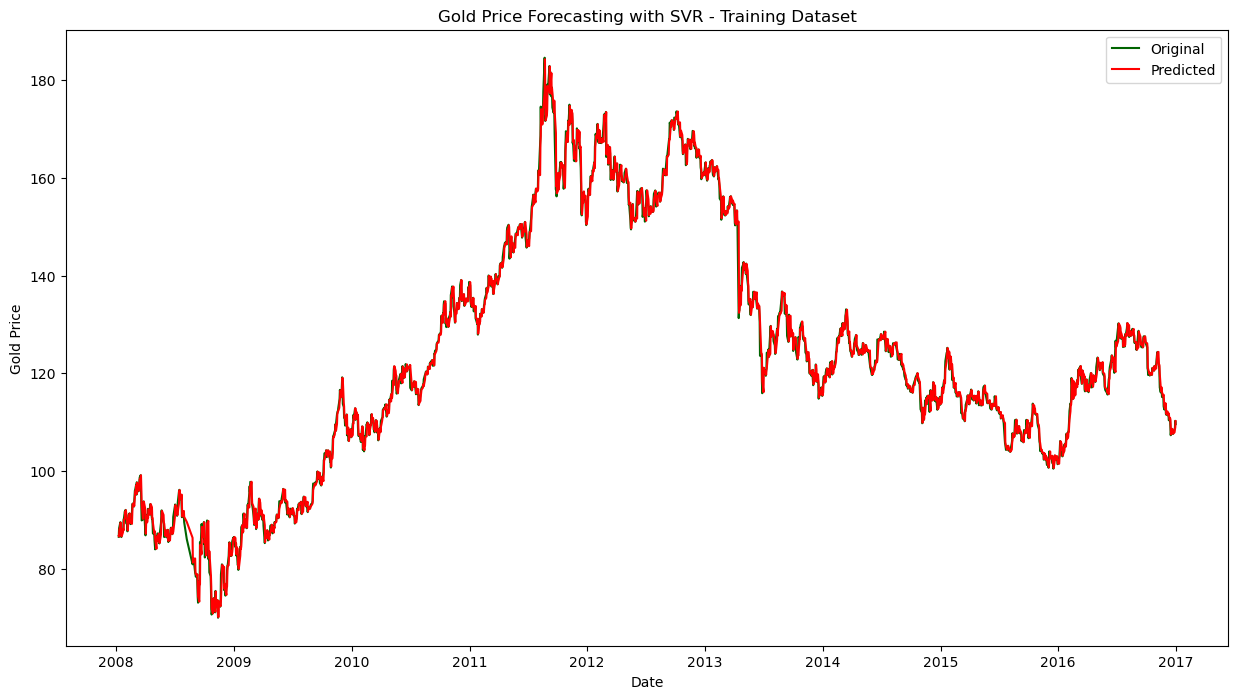

In [39]:
# Plotting the results for train dataset
plt.figure(figsize=(15, 8))
plt.plot(df.index[TIME_STEPS:TIME_STEPS+len(train_pred_inv)], y_train_inv, label='Original', color='darkgreen')
plt.plot(df.index[TIME_STEPS:TIME_STEPS+len(train_pred_inv)], train_pred_inv, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.title('Gold Price Forecasting with SVR - Training Dataset')
plt.legend()
plt.show()

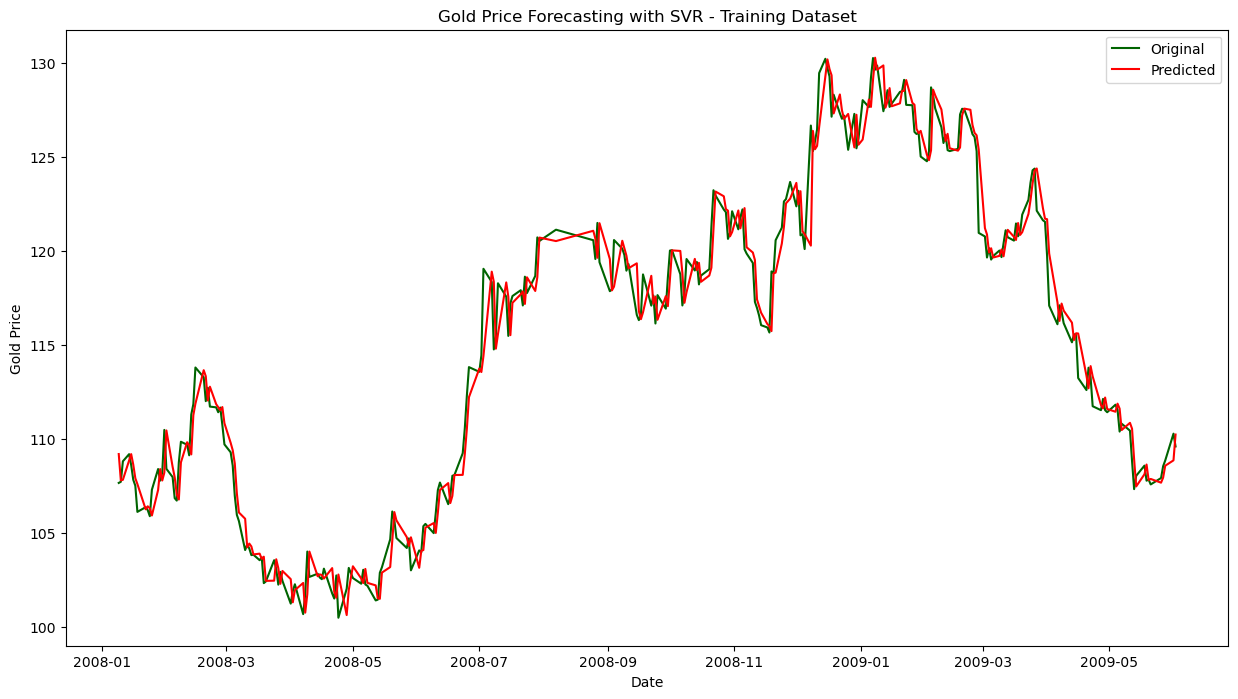

In [40]:
# Plotting the results for train dataset
plt.figure(figsize=(15, 8))
plt.plot(df.index[TIME_STEPS:TIME_STEPS+len(train_pred_inv[-300:])], y_train_inv[-300:], label='Original', color='darkgreen')
plt.plot(df.index[TIME_STEPS:TIME_STEPS+len(train_pred_inv[-300:])], train_pred_inv[-300:], label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.title('Gold Price Forecasting with SVR - Training Dataset')
plt.legend()
plt.show()

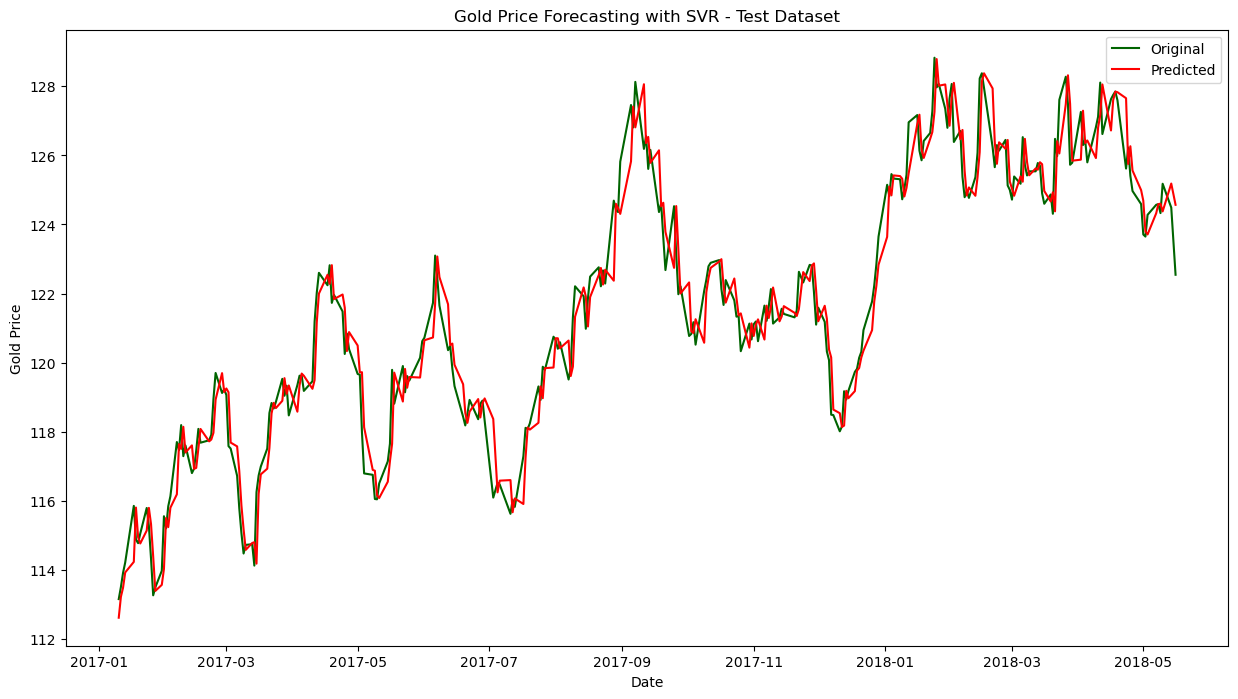

In [41]:
# Plotting the results for test dataset
plt.figure(figsize=(15, 8))
plt.plot(df.index[TIME_STEPS+len(train_pred_inv)+TIME_STEPS:], y_test_inv, label='Original', color='darkgreen')
plt.plot(df.index[TIME_STEPS+len(train_pred_inv)+TIME_STEPS:], test_pred_inv, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.title('Gold Price Forecasting with SVR - Test Dataset')
plt.legend()
plt.show()

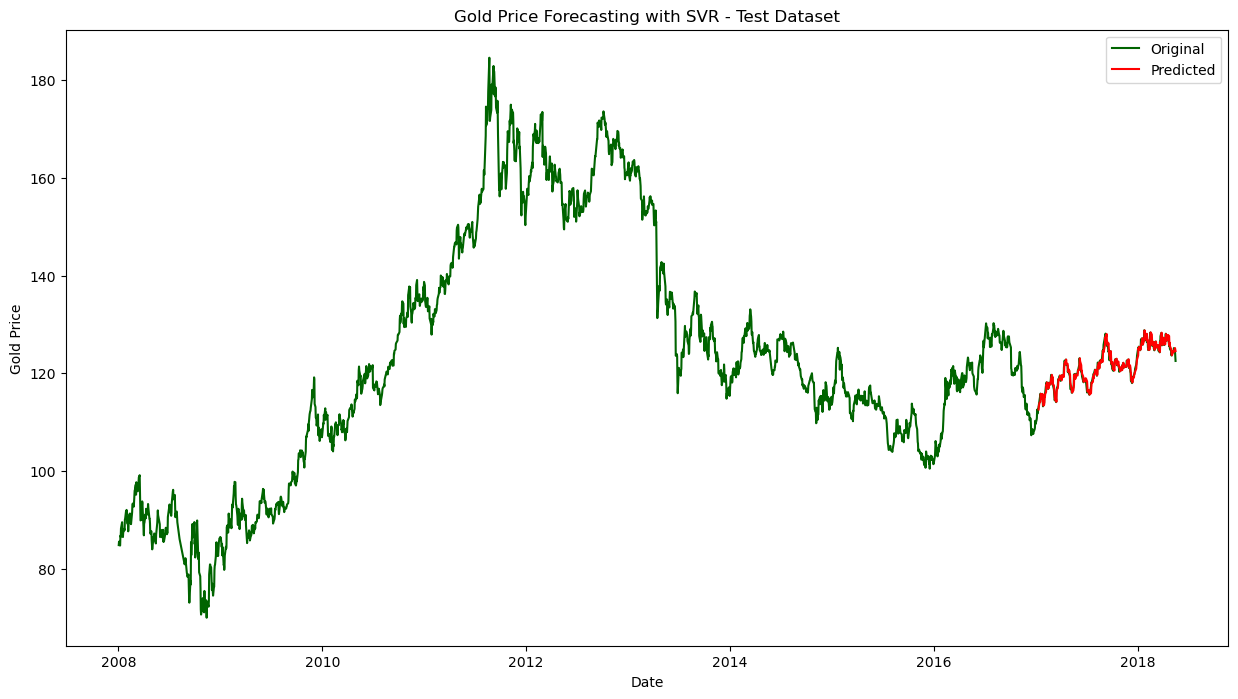

In [42]:
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['GLD'], label='Original', color='darkgreen')
plt.plot(df.index[TIME_STEPS+len(train_pred_inv)+TIME_STEPS:], test_pred_inv, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.title('Gold Price Forecasting with SVR - Test Dataset')
plt.legend()
plt.show()


In [43]:
# Tạo bảng sai số
error_table = pd.DataFrame({
    'Model': ['SVR', 'ARIMA'],
    'MSE': [mse_test_svr, mse_arima],
    'RMSE': [rmse_test_svr, rmse_arima],
    'MAE': [mae_test_svr, mae_arima],
    'MAPE': [mape_test_svr, mape_arima],
    'R^2': [r2_test_svr, r2_arima]
})

print(error_table)

   Model       MSE      RMSE       MAE      MAPE       R^2
0    SVR  0.669307  0.818112  0.640845  0.526374  0.954440
1  ARIMA  0.297848  0.545755  0.388440  0.319531  0.981111
